# Running analog Hamiltonian simulation with local simulator

We recommend to test and debug an analog Hamiltonian simulation (AHS) program on the local simulator before submitting it to a QPU. In this notebook, we introduce several features of the local simulator that will be useful to streamline this testing process.

To begin, we import the necessary packages.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

from ahs_utils import show_register, show_global_drive, plot_avg_density_2D, get_drive, get_avg_density

In [57]:
detuning = 5.5e7
amplitude = 1.57e7
C6 = 5.42e-24
Rb_min = (C6/np.sqrt((detuning)**2+(amplitude)**2))**(1/6)
Rb_max = (C6/np.sqrt((detuning)**2))**(1/6)

# separation = 5e-5 
# separation = 5e-6 
separation = (Rb_min+Rb_max)/2

print(f"Rb_min, Rb_max, separation = {Rb_min}, {Rb_max}, {separation}")

register = AtomArrangement()
register.add((0, 0))
register.add((0, separation))
register.add((0, 2 * separation))

def get_program(ramp_down_time):
    if ramp_down_time>0.0:
        time_points = [0, 2.5e-7, 2.75e-6, 2.75e-6+ramp_down_time]
        amplitude_values = [0.0, amplitude, amplitude, 0.0]  # piecewise linear
        detuning_values = [-detuning, -detuning, detuning, detuning]  # piecewise linear
        phase_values = [0, 0, 0, 0]  # piecewise constant
    else:
        time_points = [0, 2.5e-7, 2.75e-6]
        amplitude_values = [0.0, amplitude, amplitude]  # piecewise linear
        detuning_values = [-detuning, -detuning, detuning]  # piecewise linear
        phase_values = [0, 0, 0]  # piecewise constant    
        
    drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)   
    ahs_program = AnalogHamiltonianSimulation(
        register=register, 
        hamiltonian=drive
    )
    
    return ahs_program
    

Rb_min, Rb_max, separation = 6.752082623437916e-06, 6.796303522169465e-06, 6.774193072803691e-06


In [55]:
(Rb_min+Rb_max)/2

6.774193072803691e-06

In [50]:
ramp_down_times = np.linspace(0, 2.75e-6, 100)
programs = [get_program(ramp_down_time) for ramp_down_time in ramp_down_times]

In [51]:
device = LocalSimulator("braket_ahs")

In [52]:
results = [device.run(program, shots=1000).result() for program in programs]

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004027777777777778 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004055555555555555 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004083333333333334 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-pac

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004777777777777777 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004805555555555555 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/times_series.py:39: UserWarning: Max time is 0.000004833333333333333 seconds which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-pac

In [53]:
avg_dens = [get_avg_density(result) for result in results]

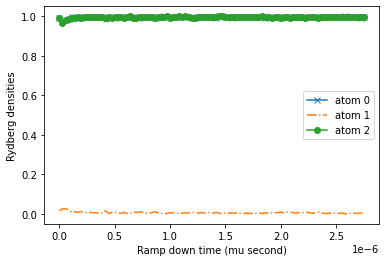

In [54]:
plt.plot(ramp_down_times, [avg_den[0] for avg_den in avg_dens], 'x-', label='atom 0')
plt.plot(ramp_down_times, [avg_den[1] for avg_den in avg_dens], '-.', label='atom 1')
plt.plot(ramp_down_times, [avg_den[2] for avg_den in avg_dens], 'o-', label='atom 2')
plt.xlabel("Ramp down time (mu second)")
plt.ylabel("Rydberg densities")
plt.legend()

## Run AHS program in the blockade subspace

The above simulation is performed using the *full* Hamiltonian with size $2^{9}\times 2^{9}$. However, because of Rydberg blockade, if neighboring atoms are within each other's Rydberg blockade radius $R_b$, they are very unlikely to be excited to the Rydberg states simultaneously. Given that (see [this notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb))
\begin{align}
R_b = \left[\frac{C_6}{\sqrt{\Delta^2+\Omega^2}}\right]^{1/6},
\end{align}

we have 6.752 $\mu m$ < $R_b$ < 6.796 $\mu m$ throughout the program, which is always larger than $6.7~ \mu m$, the distances between neighboring atoms. Hence we can approximate the full Hamiltonian of the system with a smaller *effective* Hamiltonian. We can take advantage of this fact to speed up the simulation by setting the parameter `blockade_radius` as shown below.